# Time Series Bootstrapping

In [1]:
import pandas as pd
import numpy as np

# Plotting parameters
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16,6)
from IPython.display import display

## Load Data 

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


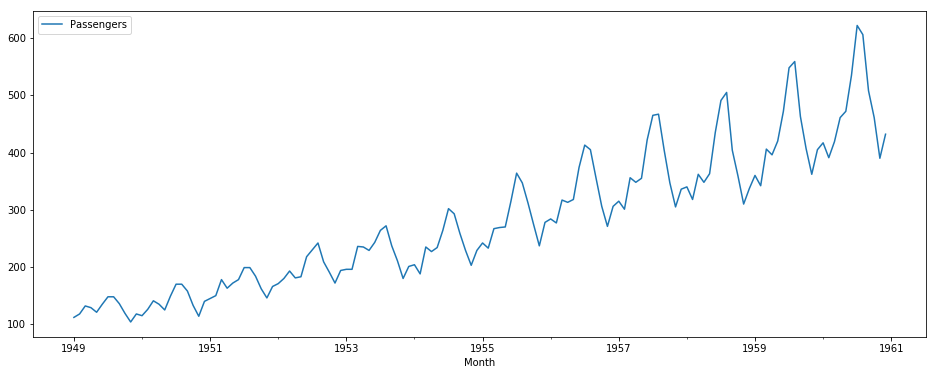

In [2]:
df_passengers = pd.read_csv('data/airline-passengers.csv', parse_dates =['Month'], index_col=['Month'])
display(df_passengers.head())

# Plot Figures 
df_passengers.plot()
plt.show()

In [8]:
def create_targets_and_features(timeseries, look_ahead, window):
    n = len(timeseries)
    # create label-feature-pairs 
    label_feature_pair = []

    for i in range(n - look_ahead - window+1):
        t = (timeseries.index[i+window+look_ahead-1], ) # date 
        y_t = (timeseries.iloc[i+window+look_ahead-1], ) # target value
        X_t = tuple(timeseries.iloc[i:i+window])[::-1] # list of features (i.e. previous values)
        label_feature_pair.append(t + y_t + X_t)

    lagged_cols = ['t-{}'.format(i) for i in range(look_ahead, look_ahead + window)]
    data = pd.DataFrame.from_records(label_feature_pair, 
                                     columns=['date', 'target'] + lagged_cols, 
                                     index='date')
    return data

In [125]:
look_ahead = 1
window = 12
data = create_targets_and_features(df_passengers['Passengers'], look_ahead=look_ahead, window=window)

data.head()

,target,t-1,t-2,t-3,t-4,t-5,t-6,t-7,t-8,t-9,t-10,t-11,t-12
date,,,,,,,,,,,,,
1950-01-01,115,118,104,119,136,148,148,135,121,129,132,118,112
1950-02-01,126,115,118,104,119,136,148,148,135,121,129,132,118
1950-03-01,141,126,115,118,104,119,136,148,148,135,121,129,132
1950-04-01,135,141,126,115,118,104,119,136,148,148,135,121,129
1950-05-01,125,135,141,126,115,118,104,119,136,148,148,135,121


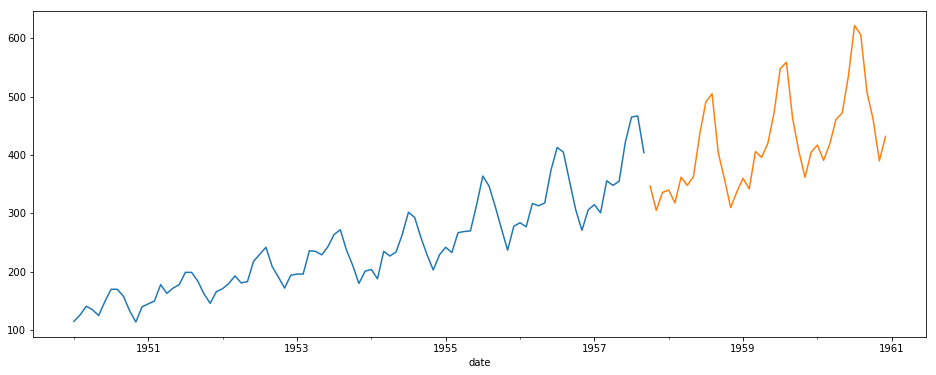

In [126]:
# Split training/testing data 
test_size = 0.3
index_test_series = int(test_size*len(data))

data_train, data_test = data.iloc[:-index_test_series], data.iloc[-index_test_series:]
data_train.tail()

ax = data_train['target'].plot()
data_test['target'].plot(ax=ax)
plt.show()



In [63]:
def sample_with_replacement(X, n_samples=None):   
    ori_idx = X.index  
    if n_samples is None:
        n_samples = len(ori_idx)    
    
    # Sample from data 
    sample_idx = np.random.choice(ori_idx, n_samples, replace=True)
    return X.loc[sample_idx]

In [77]:
from sklearn.model_selection import GroupShuffleSplit
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [79]:
# Elastic Net
model_enet = ElasticNet(fit_intercept=False)

In [127]:
n_bootstraps = 1000

label = ['target']
features = [i for i in data.columns if i not in {'target'}]

# Get test-set 
y_test, X_test = data_test[label], data_test[features]

df_bootstrap_pred = pd.DataFrame()

for sim in range(n_bootstraps):
    # sample data
    data_train_bootstrap = sample_with_replacement(data_train, n_samples=int(0.7*len(data_train)))

    # train model
    y_train, X_train = data_train_bootstrap[label], data_train_bootstrap[features]
    model_enet.fit(X_train, y_train)

    # prediction
    y_pred_bootstrap = pd.DataFrame({sim: model_enet.predict(X_test)}, 
                                    index=X_test.index)
    
    # Append to predict data frame
    df_bootstrap_pred = pd.concat([df_bootstrap_pred, y_pred_bootstrap], axis=1)


C:\Users\kanna sithan\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [102]:
def get_confidence_intervals(df, alpha=0.05):
    df_quantile = df.quantile([alpha/2, 0.5, 1-(alpha/2)], axis=1).T
    df_quantile.columns = ['lower', 'median', 'upper']
    return df_quantile


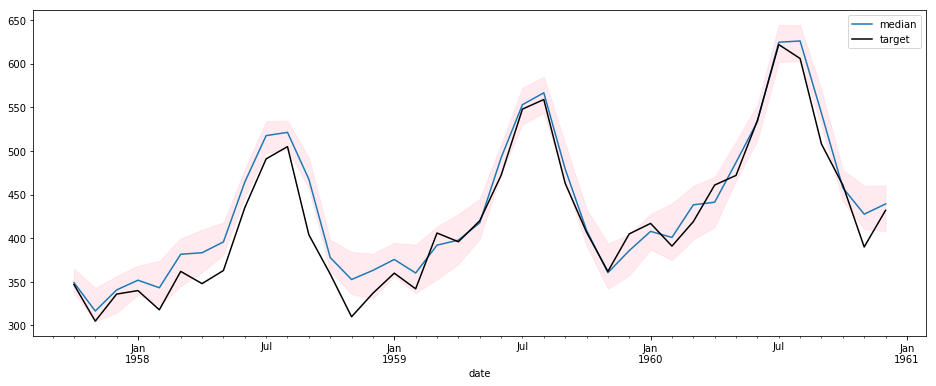

In [128]:
df_quantile = get_confidence_intervals(df_bootstrap_pred, alpha=0.05)
ax = df_quantile['median'].plot()
y_test.plot(ax=ax, color='k')
ax.fill_between(df_quantile.index, df_quantile['lower'], df_quantile['upper'], 
                color='pink', alpha=0.3)
plt.legend()
plt.show()

# Quantile Regression for Confidence Intervals

In [203]:
# Import Quantile Regession 
from statsmodels.regression.quantile_regression import QuantReg

# For R-like formulation of the problem 
import statsmodels.formula.api as smf

In [205]:
# Tranform column names so it fits into the stat-model functions 
# Statsmodel doesn't seem to like the "-" in the column names 
data_train_r = data_train.copy()
data_test_r = data_test.copy()
data_train_r.columns = [''.join(i.split('-')) for i in data_train_r.columns]
data_test_r.columns = [''.join(i.split('-')) for i in data_test_r.columns]
r_features = [i for i in data_train_r.columns if i not in {'target'}]

data_train_r.head()

,target,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t11,t12
date,,,,,,,,,,,,,
1950-01-01,115,118,104,119,136,148,148,135,121,129,132,118,112
1950-02-01,126,115,118,104,119,136,148,148,135,121,129,132,118
1950-03-01,141,126,115,118,104,119,136,148,148,135,121,129,132
1950-04-01,135,141,126,115,118,104,119,136,148,148,135,121,129
1950-05-01,125,135,141,126,115,118,104,119,136,148,148,135,121


In [227]:
# Fit Quantile Regression Model
alpha = 0.05 # 5% confidence interval 
dict_train = dict()
dict_test = dict()

for quantile in [alpha/2, 0.5, 1-(alpha/2)]:
    mod = smf.quantreg('target ~ ' +  '+'.join(r_features), data=data_train_r)
    res = mod.fit(q=quantile)
    
    y_pred_train = res.get_prediction(exog=data_train_r[r_features]).predicted_mean
    y_pred_test = res.get_prediction(exog=data_test_r[r_features]).predicted_mean
    
    print(len(y_pred_train), len(data_train_r))
    print(len(y_pred_test), len(data_test_r))
    print('')
    
    dict_train.update({quantile:y_pred_train})
    dict_test.update({quantile:y_pred_test})


df_quantile_train = pd.DataFrame(dict_train, index=data_train_r.index)
df_quantile_test = pd.DataFrame(dict_test, index=data_test_r.index)


93 93
39 39

93 93
39 39

93 93
39 39



C:\Users\kanna sithan\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\regression\quantile_regression.py:237: RuntimeWarning: invalid value encountered in less_equal
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)


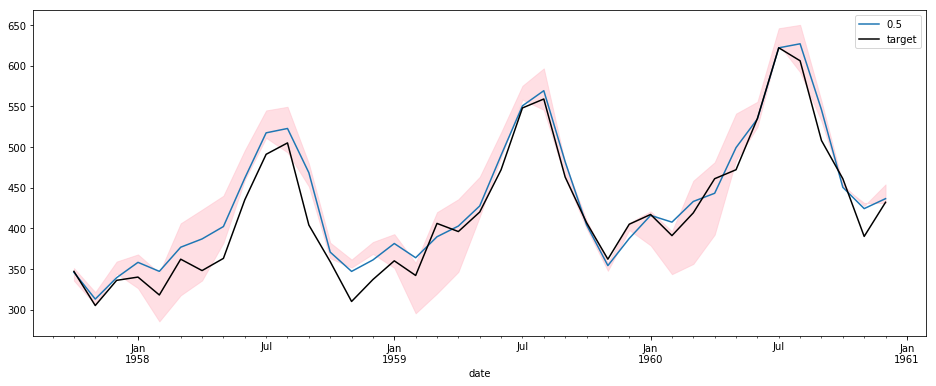

In [234]:
ax2 = df_quantile_test[0.5].plot()
ax2.fill_between(df_quantile_test.index, 
                 df_quantile_test[0.025], df_quantile_test[0.975],
                 color='pink', alpha=0.5)
data_test_r['target'].plot(ax=ax2, color='k')
plt.legend()
plt.show()

In [216]:
len(pd.DataFrame(dict_train))

len(data_train_r.index.values)

93

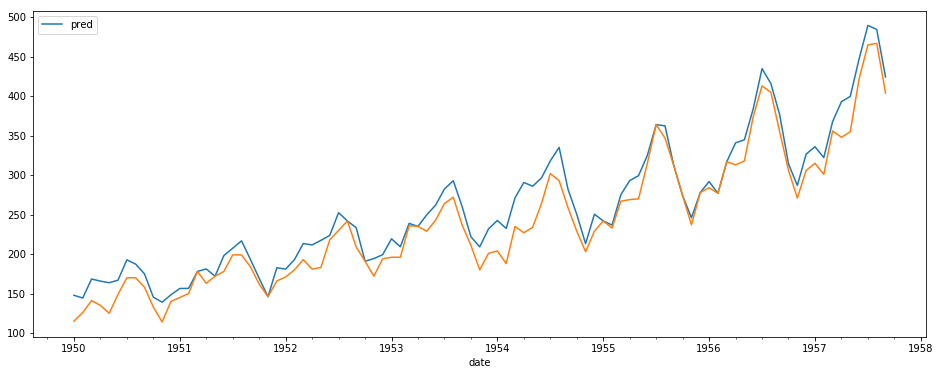

In [201]:
ax = df_results.plot()
data_train_r['target'].plot(ax=ax)
plt.show()
